In [ ]:
!pip install torch==2.9.0

In [1]:
!pip install -q unsloth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.2/379.2 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.2/295.2 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 131.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import json
import pandas as pd

import torch
from datasets import Dataset
from unsloth import FastLanguageModel
from peft import LoraConfig, AutoPeftModelForCausalLM, prepare_model_for_kbit_training, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, GPTQConfig, TrainingArguments
from trl import SFTTrainer # transformer RL library - Supervised FineTuning Trainer
import os

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
path = 'drive/MyDrive/data/train.json'

In [ ]:
data_json = []
with open(path, 'r') as file:
  for line in file:
    data_json.append(json.loads(line))

print(f'data_json[:5] : {data_json[0]}')

data_extracted = [
    {'question': entry['question'], 'cop': entry['cop'], 'subject_name': entry['subject_name'], 'topic_name': entry['topic_name'], 'exp': entry['exp'], 'opa': entry['opa'], 'opb': entry['opb'], 'opc': entry['opc'], 'opd': entry['opd'], 'exp': entry['exp']}
    for entry in data_json
]
print(f'data_extracted[:5]: {data_extracted[0]}')

data_json[:5] : {'question': 'Chronic urethral obstruction due to benign prismatic hyperplasia can lead to the following change in kidney parenchyma', 'exp': 'Chronic urethral obstruction because of urinary calculi, prostatic hyperophy, tumors, normal pregnancy, tumors, uterine prolapse or functional disorders cause hydronephrosis which by definition is used to describe dilatation of renal pelvis and calculus associated with progressive atrophy of the kidney due to obstruction to the outflow of urine Refer Robbins 7yh/9,1012,9/e. P950', 'cop': 3, 'opa': 'Hyperplasia', 'opb': 'Hyperophy', 'opc': 'Atrophy', 'opd': 'Dyplasia', 'subject_name': 'Anatomy', 'topic_name': 'Urinary tract', 'id': 'e9ad821a-c438-4965-9f77-760819dfa155', 'choice_type': 'single'}
data_extracted[:5]: {'question': 'Chronic urethral obstruction due to benign prismatic hyperplasia can lead to the following change in kidney parenchyma', 'cop': 3, 'subject_name': 'Anatomy', 'topic_name': 'Urinary tract', 'exp': 'Chronic 

In [ ]:
data_df = pd.DataFrame(data_extracted)

data_df['topic_name'] = data_df['topic_name'].fillna('Unknown')
data_df['exp'] = data_df['exp'].fillna('')

In [ ]:
data = Dataset.from_pandas(data_df)

In [ ]:
# official Mistral 7B instruct prompt
prompt_template = """
Question:
{}
[INST] Solve this post graduate medical entrance exam MCQ and provide the correct option. [/INST]
Answer: {} </s>"""

def generate_prompt(examples):
    texts = []
    # extract columns
    cops = examples['cop']
    opas = examples['opa']
    opbs = examples['opb']
    opcs = examples['opc']
    opds = examples['opd']
    questions = examples['question']

    for cop_idx, opa, opb, opc, opd, question_text in zip(cops, opas, opbs, opcs, opds, questions):
        # Build the question string with options
        question_with_options = '{}\nOptions:\n1. {}\n2. {}\n3. {}\n4. {}'.format(
            question_text, opa, opb, opc, opd
        )
        # Determine the correct answer
        if cop_idx == 1:
            answer = opa
        elif cop_idx == 2:
            answer = opb
        elif cop_idx == 3:
            answer = opc
        elif cop_idx == 4:
            answer = opd
        else:
            answer = ""  # fallback if cop_idx is invalid

        # Format prompt
        text = prompt_template.format(question_with_options, answer)
        texts.append(text)

    return {'text': texts}

# Apply to dataset
dataset = data.map(generate_prompt, batched=True)

Map:   0%|          | 0/182822 [00:00<?, ? examples/s]

In [ ]:
print(dataset[0])

{'question': 'Chronic urethral obstruction due to benign prismatic hyperplasia can lead to the following change in kidney parenchyma', 'cop': 3, 'subject_name': 'Anatomy', 'topic_name': 'Urinary tract', 'exp': 'Chronic urethral obstruction because of urinary calculi, prostatic hyperophy, tumors, normal pregnancy, tumors, uterine prolapse or functional disorders cause hydronephrosis which by definition is used to describe dilatation of renal pelvis and calculus associated with progressive atrophy of the kidney due to obstruction to the outflow of urine Refer Robbins 7yh/9,1012,9/e. P950', 'opa': 'Hyperplasia', 'opb': 'Hyperophy', 'opc': 'Atrophy', 'opd': 'Dyplasia', 'text': '\nQuestion:\nChronic urethral obstruction due to benign prismatic hyperplasia can lead to the following change in kidney parenchyma\nOptions:\n1. Hyperplasia\n2. Hyperophy\n3. Atrophy\n4. Dyplasia\n[INST] Solve this post graduate medical entrance exam MCQ and provide the correct option. [/INST]\nAnswer: Atrophy </s>

In [5]:
from huggingface_hub import notebook_login
notebook_login()

In [6]:
max_seq_length = 2048 # Choose any! Unsloth also supports RoPE (Rotary Positinal Embedding) scaling internally.
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name ='unsloth/mistral-7b-instruct-v0.2-bnb-4bit',
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit
)

==((====))==  Unsloth 2026.1.1: Fast Mistral patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model_name:Specifies the name of the pre-trained model to load.


max_seq_length:Defines the maximum sequence length (in tokens) that the model can process. max_seq_length = 2048 allows the model to process sequences up to 2048 tokens long.


dtype:Specifies the data type for model weights and computations. None: Automatically selects the appropriate data type based on the hardware. torch.
float16: Uses 16-bit floating point precision, reducing memory usage and potentially increasing speed on compatible GPUs. torch.bfloat16: Similar to float16 but with a wider dynamic range, beneficial for certain hardware like NVIDIA A100 GPUs.


load_in_4bit:Determines whether to load the model using 4-bit quantization.Ideal for scenarios where memory efficiency is crucial, such as deploying models on edge devices or during experimentation.


Now, we'll use the get_peft_model from unsloth's FastLanguageModel class to attach adapters (peft layers) on top of the models in order to perform QLoRA

In [ ]:
# define the LoRA configuration for PEFT
model = FastLanguageModel.get_peft_model(
                    model,
                    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
                    lora_alpha = 32, # a higher alpha value assigns more weight to the LoRA activations
                    lora_dropout = 0, # Supports any, but = 0 is optimized
                    bias = "none",    # Supports any, but = "none" is optimized
                    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
                    random_state = 3407,
                    use_rslora = False,
                    loftq_config = None,
                    target_modules=[
                        "q_proj", #Wq + delta(W)
                        "k_proj", #Wk + delta(k)
                        "v_proj",
                        "o_proj",
                        # matrices for the fully-connected layer
                        "gate_proj",
                        "up_proj",
                        "down_proj",
                        "lm_head",
                    ]
                )

Unsloth: Offloading output_embeddings to disk to save VRAM


/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:1222: UserWarning: Model has `tie_word_embeddings=True` and a tied layer is part of the adapter, but `ensure_weight_tying` is not set to True. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. Check the discussion here: https://github.com/huggingface/peft/issues/2777
  warnings.warn(msg)
Unsloth 2026.1.1 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Unsloth: Training lm_head in mixed precision to save VRAM


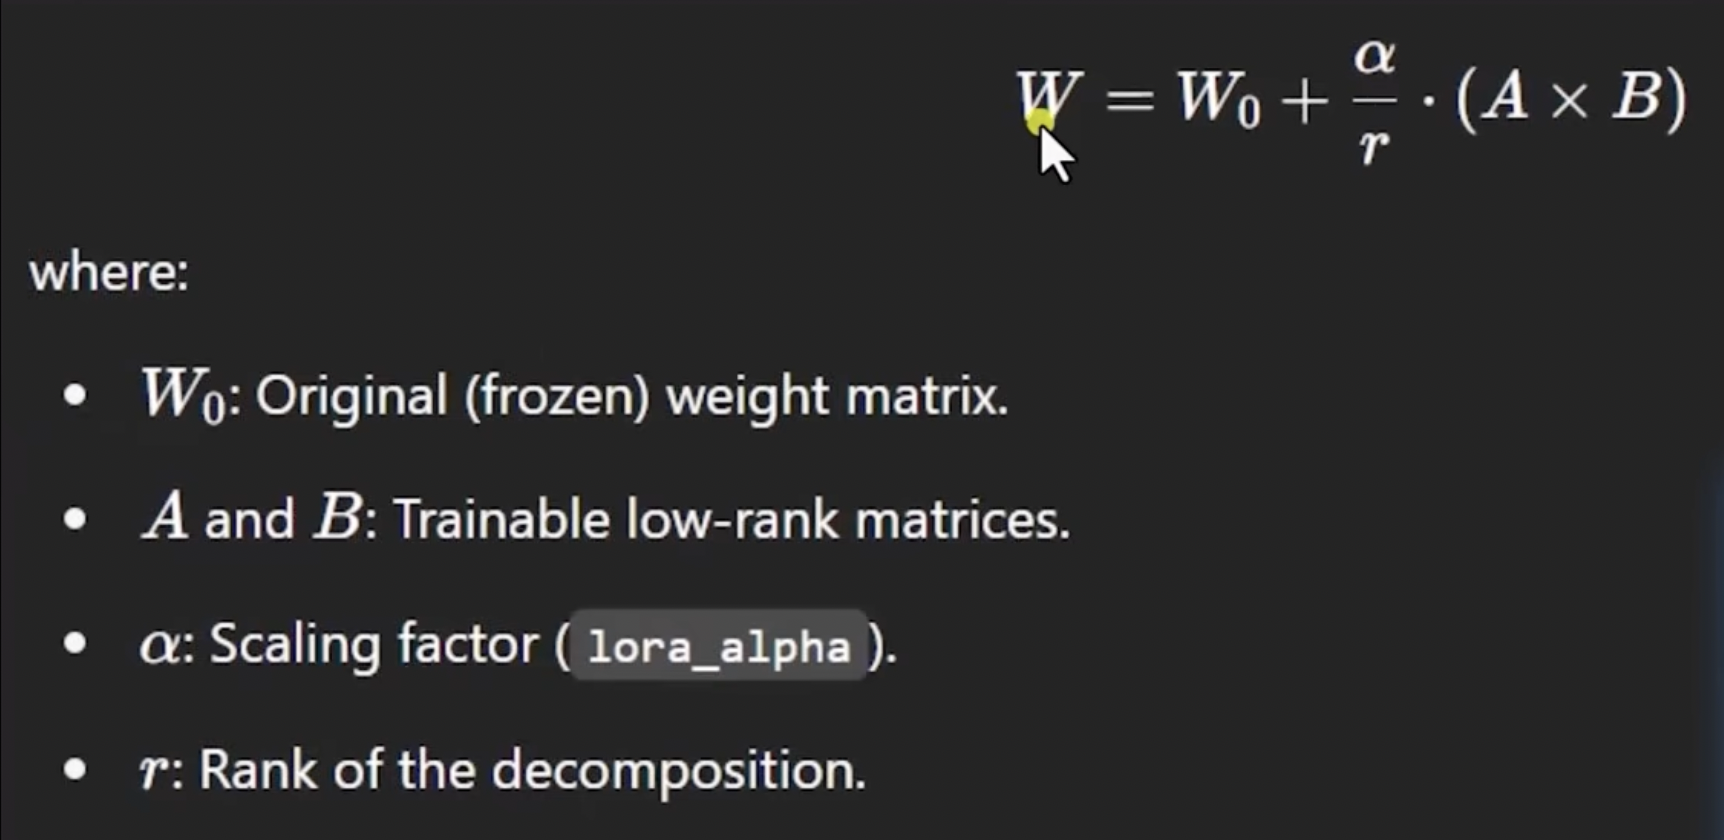

r: The rank of the low-rank matrices in LoRA; higher values can capture more information but increase memory usage.


target_modules: List of model components (e.g., "q_proj", "k_proj") where LoRA adapters are inserted for fine-tuning.


lora_alpha: Scaling factor for the LoRA updates; controls the impact of the adapters on the model's outputs.


lora_dropout: Dropout rate applied to LoRA layers during training to prevent overfitting.


bias: Specifies how biases are handled in LoRA layers; options include "none", "all", or "lora_only".


use_gradient_checkpointing: Enables gradient checkpointing to reduce memory usage during training; "unsloth" uses Unsloth's optimized version.


random_state: Seed for random number generators to ensure reproducibility of training results.


use_rslora: Boolean indicating whether to use Rank-Stabilized LoRA (rsLoRA) for potentially more stable training.


` loftq_config: Configuration for Low-Rank Quantization (LoftQ); set to None to disable this feature.

Trainer Setup:

model and tokenizer: These are the model and tokenizer objects that will be trained.

train_dataset: The dataset used for training.

dataset_text_field: Specifies the field in the dataset that contains the text data.

max_seq_length: Maximum sequence length for the input data.

dataset_num_proc: Number of processes to use for data loading.

packing: If True, enables sequence packing (concatenates multiple examples into a single sequence to better utilize tokens).

Training Arguments:

per_device_train_batch_size: Number of samples per batch for each device.

gradient_accumulation_steps: Number of steps to accumulate gradients before updating model weights.

warmup_steps: Number of steps for learning rate warmup.

max_steps: Total number of training steps.

learning_rate: Learning rate for the optimizer.

fp16 and bf16: Specifies whether to use 16-bit floating point precision or bfloat16, depending on hardware support.

logging_steps: Frequency of logging training progress.

optim: Optimizer type, here using an 8-bit version of AdamW.

weight_decay: Regularization parameter for weight decay.

lr_scheduler_type: Type of learning rate scheduler.

seed: Random seed for reproducibility.

output_dir: Directory where the training outputs will be saved.

report_to: Integration for observability tools like "wandb", "tensorboard", etc.

In [ ]:
from unsloth import is_bfloat16_supported

training_arguments = TrainingArguments(
            output_dir="mistral-lora-finetuned-medmcqa",
            per_device_train_batch_size = 8, # The batch size per GPU/TPU core
            gradient_accumulation_steps = 1, # Number of steps to perform befor each gradient accumulation
            warmup_steps = 5, # Few updates with low learning rate before actual training
            max_steps = 5000, # Specifies the total number of training steps (batches) to run.
            learning_rate = 2e-4,
            fp16 = not is_bfloat16_supported(),
            bf16 = is_bfloat16_supported(),
            logging_steps = 50,
            num_train_epochs=1,
            optim="paged_adamw_32bit", # Optimizer
            weight_decay = 0.01,
            lr_scheduler_type = "cosine",
            seed = 3407,
            save_strategy="epoch",
            report_to = "none", # Use this for WandB etc for observability
            push_to_hub = True
    )

trainer = SFTTrainer(
            model = model,
            tokenizer = tokenizer,
            train_dataset = dataset,
            dataset_text_field = "text",
            max_seq_length = max_seq_length,
            dataset_num_proc = 2, # Number of processors to use for processing the dataset
            packing = False, # Can make training 5x faster for short sequences.
            args = training_arguments
    )

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/182822 [00:00<?, ? examples/s]

In [ ]:
trainer_stats = trainer.train()
trainer.push_to_hub()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 2
   \\   /|    Num examples = 182,822 | Num Epochs = 1 | Total steps = 5,000
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 1 x 1) = 8
 "-____-"     Trainable parameters = 173,015,040 of 7,414,747,136 (2.33% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
50,1.622500
100,1.269000
150,1.223500
200,1.244500
250,1.263700
300,1.216300
350,1.206400
400,1.224000
450,1.209200
500,1.211600


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...medmcqa/training_args.bin: 100%|##########| 6.22kB / 6.22kB            

  ...d-medmcqa/tokenizer.model: 100%|##########|  493kB /  493kB            

  ...adapter_model.safetensors:   5%|4         | 33.5MB /  692MB            

CommitInfo(commit_url='https://huggingface.co/srao0996/mistral-lora-finetuned-medmcqa/commit/7231b5998bdcf071a4ae6220fc175bb7380cc358', commit_message='End of training', commit_description='', oid='7231b5998bdcf071a4ae6220fc175bb7380cc358', pr_url=None, repo_url=RepoUrl('https://huggingface.co/srao0996/mistral-lora-finetuned-medmcqa', endpoint='https://huggingface.co', repo_type='model', repo_id='srao0996/mistral-lora-finetuned-medmcqa'), pr_revision=None, pr_num=None)

In [7]:
# Inference
path = "drive/MyDrive/data/dev.json"
val_data_json = []
with open(path, 'r') as file:
    for line in file:
        val_data_json.append(json.loads(line))

val_data_extracted = [
    {'question': entry['question'], 'cop': entry['cop'], 'opa': entry['opa'], 'opb': entry['opb'], 'opc': entry['opc'], 'opd': entry['opd']}
    for entry in val_data_json
]

val_data_df = pd.DataFrame(val_data_extracted)

In [8]:
def generate_test_prompt(x):
    question = '{}\nOptions:\n1. {}\n2. {}\n3. {}\n4. {}\n'.format(x['question'], x['opa'], x['opb'], x['opc'], x['opd'])
    prompt = f"""
    Question:
    {question}
    [INST] Solve this post graduate medical entrance exam MCQ and answer correctly. [/INST]
    Answer: """
    return prompt
val_data_df['text'] = val_data_df.apply(lambda x: generate_test_prompt(x), axis=1)

In [9]:
val_data_df['text'][0]

'\n    Question:\n    Which of the following is not true for myelinated nerve fibers:\nOptions:\n1. Impulse through myelinated fibers is slower than non-myelinated fibers\n2. Membrane currents are generated at nodes of Ranvier\n3. Saltatory conduction of impulses is seen\n4. Local anesthesia is effective only when the nerve is not covered by myelin sheath\n\n    [INST] Solve this post graduate medical entrance exam MCQ and answer correctly. [/INST]\n    Answer: '

In [10]:
from huggingface_hub import list_repo_files
print(list_repo_files("srao0996/mistral-lora-finetuned-medmcqa"))


['.gitattributes', 'README.md', 'adapter_config.json', 'adapter_model.safetensors', 'chat_template.jinja', 'special_tokens_map.json', 'tokenizer.json', 'tokenizer.model', 'tokenizer_config.json', 'training_args.bin']


In [11]:
model1, tokenizer1 = FastLanguageModel.from_pretrained(
    model_name ='srao0996/mistral-lora-finetuned-medmcqa',
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit
)
FastLanguageModel.for_inference(model1) # Enable native 2x faster inference

# import gc
# gc.collect()
# torch.cuda.empty_cache()

inputs = tokenizer1(
    val_data_df['text'][4],
    return_tensors = "pt",
).to("cuda")

outputs = model1.generate(**inputs, max_new_tokens = 64, use_cache = True,
                         temperature = 0.2, min_p = 0.1)
response = tokenizer1.batch_decode(outputs)

==((====))==  Unsloth 2026.1.1: Fast Mistral patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:1222: UserWarning: Model has `tie_word_embeddings=True` and a tied layer is part of the adapter, but `ensure_weight_tying` is not set to True. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. Check the discussion here: https://github.com/huggingface/peft/issues/2777
  warnings.warn(msg)


adapter_model.safetensors:   0%|          | 0.00/692M [00:00<?, ?B/s]

Unsloth 2026.1.1 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [12]:
response

['<s> \n    Question:\n    Low insulin to glucagon ratio is seen in all of these except:\nOptions:\n1. Glycogen synthesis\n2. Glycogen breakdown\n3. Gluconeogenesis\n4. Ketogenesis\n\n    [INST] Solve this post graduate medical entrance exam MCQ and answer correctly. [/INST]\n    Answer:  Glycogen breakdown </s>']

In [13]:
outputs

tensor([[    1, 28705,    13,  2287, 22478, 28747,    13,  2287, 13091,  1488,
         24726,   298,  1272,  1485,  4959, 10554,   349,  2598,   297,   544,
           302,  1167,  3741, 28747,    13,  4018, 28747,    13, 28740, 28723,
           420,   346, 28717,  8371, 13606, 21537,    13, 28750, 28723,   420,
           346, 28717,  8371, 26987,    13, 28770, 28723,  3651, 28718,   514,
         28706,  8371, 14699,    13, 28781, 28723,   524,   299,  8371, 14699,
            13,    13,  2287,   733, 16289, 28793,   318,  5303,   456,  1704,
         16174,  5714, 12675,  4174, 16416, 28824,   304,  4372, 12742, 28723,
           733, 28748, 16289, 28793,    13,  2287, 26307, 28747, 28705,   420,
           346, 28717,  8371, 26987, 28705,     2]], device='cuda:0')

In [14]:
def solve_question(question_prompt):
    inputs = tokenizer1(question_prompt, return_tensors="pt", padding=True, truncation=True).to("cuda")

    outputs = model1.generate(**inputs, max_new_tokens = 64, use_cache = True,
                         temperature = 0.2, min_p = 0.1)
    answer = tokenizer1.batch_decode(outputs, skip_special_tokens=True)
    return answer

In [15]:
all_answers = []
import re
import tqdm
val_data_prompts = list(val_data_df['text'])
for i in tqdm.tqdm(range(0, len(val_data_prompts), 16)):
    question_prompts = val_data_prompts[i:i+16]
    ans = solve_question(question_prompts)
    ans_option = []
    for text in ans:
        ans_option.append(re.search(r'Answer: \s*(.*)', text).group(1))

    all_answers.extend(ans_option)

100%|██████████| 262/262 [1:09:47<00:00, 15.98s/it]


In [16]:
len(all_answers)

4183

In [17]:
correct_answers = []
for i in range(len(val_data_df)):
    if val_data_df['cop'][i] == 1:
        correct_answers.append(val_data_df['opa'][i])
    elif val_data_df['cop'][i] == 2:
        correct_answers.append(val_data_df['opb'][i])
    elif val_data_df['cop'][i] == 3:
        correct_answers.append(val_data_df['opc'][i])
    elif val_data_df['cop'][i] == 4:
        correct_answers.append(val_data_df['opd'][i])

In [18]:
len(correct_answers)

4183

In [19]:
def normalize(text):
    if not text.strip():
        return ""
    text = text.lower()
    text = re.sub(r'^\d+\.\s*', '', text)      # remove numbering
    text = re.sub(r'[^\w\s%/.-]', '', text)    # remove punctuation
    text = re.sub(r'\s+', ' ', text)           # normalize spaces
    return text.strip()

In [20]:
correct_count = 0
for i in range(len(val_data_df)):
    print(f'{correct_answers[i]} ";" {all_answers[i]}')
    left, right = correct_answers[i], all_answers[i]

    left_n = normalize(left)
    right_n = normalize(right)

    if left_n == right_n:
        correct_count += 1

correct_count/len(val_data_df)

Impulse through myelinated fibers is slower than non-myelinated fibers ";" 1 
The oncotic pressure of the fluid leaving the capillaries is less than that of fluid entering it ";" 1. The oncotic pressure of the fluid leaving the capillaries is less than that of fluid entering it 
Amniotic fluid samples plus chromosomal analysis will definitely tell her that next baby will be down syndromic or not ";" blood screening at this point of time will clear the exact picture 
Antegrade and retrograde ";" 1 
Glycogen synthesis ";" 1 
0.01 ";" 0.01 
Pregnant woman with sore throat can be staed immediately on oseltamivir without diagnostic testing under category B ";" 1 
Anterior ethmoidal aery ";" 4 
Electrical alternans ";" 1. Electrical alternans 
Pulmonary atresia ";" Ebstein's anomaly 
Dentinoenamel junction ";" 27.	
Before performing the ABG, syringe should be loaded with 0.3 cc of heparin ";" 1. Normal pH, HCO. and PCO, levels may not indicate absence of an acid-base imbalance 
Pre-Botzinger

0.2493425770977767

In [21]:
threshold_score = 0.5
matching_scores = [sum(normalize(g) == normalize(t) for g, t in zip(gen, truth)) / max(len(gen), len(truth)) for gen, truth in zip(all_answers, correct_answers)]
correct_count = sum(score >= threshold_score for score in matching_scores)
correct_count/len(val_data_df)

0.27898637341620847

In [22]:
print(all_answers[:5])
print(correct_answers[:5])

['1 ', '1. The oncotic pressure of the fluid leaving the capillaries is less than that of fluid entering it ', 'blood screening at this point of time will clear the exact picture ', '1 ', '1 ']
['Impulse through myelinated fibers is slower than non-myelinated fibers', 'The oncotic pressure of the fluid leaving the capillaries is less than that of fluid entering it', 'Amniotic fluid samples plus chromosomal analysis will definitely tell her that next baby will be down syndromic or not', 'Antegrade and retrograde', 'Glycogen synthesis']
